## Importing Data and Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import os
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
import pickle
from gensim.models import Word2Vec
from collections import Counter
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle

In [5]:
df = pd.read_csv('/content/questions.csv')
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

## Check for Missing Values

In [7]:
df = df.iloc[:1000]

In [8]:
df.shape

(1000, 6)

In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
df = df.dropna()

In [11]:
df.shape

(1000, 6)

## Inspecting Data Uniqueness and Distribution

In [12]:
# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Check the distribution of the target column `is_duplicate`
print(df['is_duplicate'].value_counts())

Number of duplicate rows: 0
is_duplicate
0    620
1    380
Name: count, dtype: int64


## Checking for Class Balance

In [13]:
duplicate_percentage = df['is_duplicate'].mean() * 100
print(f"Percentage of duplicate pairs: {duplicate_percentage:.2f}%")
print(f"Percentage of non-duplicate pairs: {100 - duplicate_percentage:.2f}%")

Percentage of duplicate pairs: 38.00%
Percentage of non-duplicate pairs: 62.00%


## Remove Columns

In [14]:
# Remove the 'id', 'qid1', and 'qid2' columns
df = df.drop(['id', 'qid1', 'qid2'], axis=1)

# Display the updated DataFrame
df.head()

question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

## Text Preprocessing

In [15]:
def preprocess_text(text):
    # Check for NaN values and return an empty string or the original text
    if pd.isna(text):
        return ''

    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Removing extra whitespaces
    text = ' '.join(tokens)

    return text

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
# Preprocess the questions
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

# Display the updated DataFrame
df[['question1', 'question2']].head()

question1  \
0          step step guide invest share market india   
1                    story kohinoor kohinoor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                           question2  
0                step step guide invest share market  
1  would happen indian government stole kohinoor ...  
2               internet speed increased hacking dns  
3                    find remainder mathmath divided  
4                      fish would survive salt water

In [18]:
df.head()

question1  \
0          step step guide invest share market india   
1                    story kohinoor kohinoor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                           question2  is_duplicate  
0                step step guide invest share market             0  
1  would happen indian government stole kohinoor ...             0  
2               internet speed increased hacking dns             0  
3                    find remainder mathmath divided             0  
4                      fish would survive salt water             0

## Feature Engineering

In [19]:
# Word Overlap Features
def jaccard_similarity(q1, q2):
    a = set(q1.split())
    b = set(q2.split())

    if len(a) == 0 and len(b) == 0:
        return 1.0
    elif len(a) == 0 or len(b) == 0:
        return 0.0

    return len(a.intersection(b)) / len(a.union(b))

df['jaccard'] = df.apply(lambda row: jaccard_similarity(row['question1'], row['question2']), axis=1)

In [20]:
df.head()

question1  \
0          step step guide invest share market india   
1                    story kohinoor kohinoor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                           question2  is_duplicate   jaccard  
0                step step guide invest share market             0  0.833333  
1  would happen indian government stole kohinoor ...             0  0.222222  
2               internet speed increased hacking dns             0  0.222222  
3                    find remainder mathmath divided             0  0.000000  
4                      fish would survive salt water             0  0.153846

In [21]:
def compute_token_features(row):
    q1 = row['question1'].split()
    q2 = row['question2'].split()

    # Convert to sets for comparison
    tokens_q1 = set(q1)
    tokens_q2 = set(q2)

    # Count common words
    cwc = len(tokens_q1.intersection(tokens_q2))

    # Count common stop words
    csc = len(tokens_q1.intersection(tokens_q2).intersection(stop_words))

    # Length of questions
    len_q1, len_q2 = len(tokens_q1), len(tokens_q2)

    # Token Features
    cwc_min = cwc / min(len_q1, len_q2) if min(len_q1, len_q2) > 0 else 0
    cwc_max = cwc / max(len_q1, len_q2) if max(len_q1, len_q2) > 0 else 0

    csc_min = csc / min(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) if min(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) > 0 else 0

    csc_max = csc / max(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) if max(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) > 0 else 0

    # Common Tokens
    ctc_min = cwc / min(len_q1, len_q2) if min(len_q1, len_q2) > 0 else 0
    ctc_max = cwc / max(len_q1, len_q2) if max(len_q1, len_q2) > 0 else 0

    # Last and first word equality
    last_word_eq = int(q1[-1] == q2[-1]) if q1 and q2 else 0
    first_word_eq = int(q1[0] == q2[0]) if q1 and q2 else 0

    return pd.Series([cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq])

In [22]:
def compute_length_features(row):
    len_q1 = len(row['question1'].split())
    len_q2 = len(row['question2'].split())

    mean_len = (len_q1 + len_q2) / 2
    abs_len_diff = abs(len_q1 - len_q2)

    # Finding longest common substring ratio
    def longest_common_substring_ratio(s1, s2):
        # Find longest common substring using dynamic programming
        max_length = 0
        for i in range(len(s1)):
            for j in range(len(s2)):
                length = 0
                while (i + length < len(s1)) and (j + length < len(s2)) and (s1[i + length] == s2[j + length]):
                    length += 1
                max_length = max(max_length, length)
        return max_length / min(len(s1), len(s2)) if min(len(s1), len(s2)) > 0 else 0

    longest_substr_ratio = longest_common_substring_ratio(row['question1'], row['question2'])

    return pd.Series([mean_len, abs_len_diff, longest_substr_ratio])

In [23]:
def compute_fuzzy_features(row):
    q1, q2 = row['question1'], row['question2']

    fuzz_ratio = fuzz.ratio(q1, q2)
    fuzz_partial_ratio = fuzz.partial_ratio(q1, q2)
    token_sort_ratio = fuzz.token_sort_ratio(q1, q2)
    token_set_ratio = fuzz.token_set_ratio(q1, q2)

    return pd.Series([fuzz_ratio, fuzz_partial_ratio, token_sort_ratio, token_set_ratio])

In [24]:
stop_words = set(stopwords.words('english'))

In [25]:
token_features = df[['question1', 'question2']].apply(compute_token_features, axis=1)
token_features.columns = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq']

In [26]:
token_features

cwc_min   cwc_max  csc_min  csc_max   ctc_min   ctc_max  last_word_eq  \
0    1.000000  0.833333      0.0      0.0  1.000000  0.833333           0.0   
1    0.666667  0.250000      0.0      0.0  0.666667  0.250000           0.0   
2    0.400000  0.333333      0.0      0.0  0.400000  0.333333           0.0   
3    0.000000  0.000000      0.0      0.0  0.000000  0.000000           0.0   
4    0.400000  0.200000      0.0      0.0  0.400000  0.200000           0.0   
..        ...       ...      ...      ...       ...       ...           ...   
995  0.000000  0.000000      0.0      0.0  0.000000  0.000000           0.0   
996  0.500000  0.333333      0.0      0.0  0.500000  0.333333           0.0   
997  0.000000  0.000000      0.0      0.0  0.000000  0.000000           0.0   
998  0.538462  0.500000      0.0      0.0  0.538462  0.500000           1.0   
999  0.000000  0.000000      0.0      0.0  0.000000  0.000000           0.0   

     first_word_eq  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
..             ...  
995            0.0  
996            0.0  
997            0.0  
998            0.0  
999            0.0  

[1000 rows x 8 columns]

In [27]:
token_features.isnull().sum()

cwc_min          0
cwc_max          0
csc_min          0
csc_max          0
ctc_min          0
ctc_max          0
last_word_eq     0
first_word_eq    0
dtype: int64

In [28]:
length_features = df.apply(compute_length_features, axis=1)
length_features.columns = ['mean_len', 'abs_len_diff', 'longest_substr_ratio']

In [29]:
length_features

mean_len  abs_len_diff  longest_substr_ratio
0         6.5           1.0              1.000000
1         6.5           5.0              0.838710
2         5.5           1.0              0.250000
3         3.5           1.0              0.047619
4         7.5           5.0              0.206897
..        ...           ...                   ...
995       8.0           2.0              0.071429
996       7.5           3.0              0.263158
997       5.5           1.0              0.129032
998      14.0           0.0              0.244681
999       4.0           0.0              0.142857

[1000 rows x 3 columns]

In [30]:
length_features.isnull().sum()

mean_len                0
abs_len_diff            0
longest_substr_ratio    0
dtype: int64

In [31]:
fuzzy_features = df.apply(compute_fuzzy_features, axis=1)
fuzzy_features.columns = ['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']

In [32]:
fuzzy_features

fuzz_ratio  fuzz_partial_ratio  token_sort_ratio  token_set_ratio
0            92                 100                92              100
1            59                  94                59               84
2            55                  46                65               65
3            23                  29                23               23
4            25                  52                40               51
..          ...                 ...               ...              ...
995          22                  40                28               28
996          35                  53                54               64
997          25                  29                32               32
998          42                  59                67               69
999          33                  33                23               23

[1000 rows x 4 columns]

In [33]:
fuzzy_features.isnull().sum()

fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [34]:
df = pd.concat([df, token_features, length_features, fuzzy_features], axis=1)

In [35]:
df.head()

question1  \
0          step step guide invest share market india   
1                    story kohinoor kohinoor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                           question2  is_duplicate   jaccard  \
0                step step guide invest share market             0  0.833333   
1  would happen indian government stole kohinoor ...             0  0.222222   
2               internet speed increased hacking dns             0  0.222222   
3                    find remainder mathmath divided             0  0.000000   
4                      fish would survive salt water             0  0.153846   

    cwc_min   cwc_max  csc_min  csc_max   ctc_min   ctc_max  last_word_eq  \
0  1.000000  0.833333      0.0      0.0  1.000000  0.833333           0.0   
1  0.666667  0.250000      0.0      0.0  0.666667  0.250000           0.0   
2  0.400000  0.333333      0.0      0.0  0.400000  0.333333           0.0   
3  0.000000  0.000000      0.0      0.0  0.000000  0.000000           0.0   
4  0.400000  0.200000      0.0      0.0  0.400000  0.200000           0.0   

   first_word_eq  mean_len  abs_len_diff  longest_substr_ratio  fuzz_ratio  \
0            1.0       6.5           1.0              1.000000          92   
1            0.0       6.5           5.0              0.838710          59   
2            0.0       5.5           1.0              0.250000          55   
3            0.0       3.5           1.0              0.047619          23   
4            0.0       7.5           5.0              0.206897          25   

   fuzz_partial_ratio  token_sort_ratio  token_set_ratio  
0                 100                92              100  
1                  94                59               84  
2                  46                65               65  
3                  29                23               23  
4                  52                40               51

In [36]:
# Combine question1 and question2 into a single list for TF-IDF
questions_combined = df['question1'].tolist() + df['question2'].tolist()

In [37]:
questions_combined

['step step guide invest share market india',
 'story kohinoor kohinoor diamond',
 'increase speed internet connection using vpn',
 'mentally lonely solve',
 'one dissolve water quikly sugar salt methane carbon di oxide',
 'astrology capricorn sun cap moon cap risingwhat say',
 'buy tiago',
 'good geologist',
 'use instead',
 'motorola company hack charter motorolla dcx',
 'method find separation slit using fresnel biprism',
 'read find youtube comment',
 'make physic easy learn',
 'first sexual experience like',
 'law change status student visa green card u compare immigration law canada',
 'would trump presidency mean current international master student f visa',
 'manipulation mean',
 'girl want friend guy reject',
 'many quora user posting question readily answered google',
 'best digital marketing institution banglore',
 'rocket look white',
 'whats causing someone jealous',
 'question ask quora',
 'much kv hp',
 'mean every time look clock number',
 'tip making job interview proc

## Add TF-IDF Features

In [38]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=0.95, max_features=3000)

In [39]:
# Fit and transform the combined questions
tfidf_matrix = tfidf_vectorizer.fit_transform(questions_combined)

In [40]:
# Save TF-IDF model
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [41]:
tfidf_matrix.shape

(2000, 3000)

In [42]:
# Convert the sparse matrix to a DataFrame
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())

In [43]:
num_questions = len(df)
tfidf_question1 = tfidf_matrix[:num_questions, :]
tfidf_question2 = tfidf_matrix[num_questions:, :]

In [44]:
tfidf_question1_df = pd.DataFrame.sparse.from_spmatrix(tfidf_question1)
tfidf_question2_df = pd.DataFrame.sparse.from_spmatrix(tfidf_question2)

In [45]:
tfidf_question1_df.columns = [f'tfidf_q1_{i}' for i in range(tfidf_question1_df.shape[1])]
tfidf_question2_df.columns = [f'tfidf_q2_{i}' for i in range(tfidf_question2_df.shape[1])]

In [46]:
tfidf_question1_df

tfidf_q1_0  tfidf_q1_1  tfidf_q1_2  tfidf_q1_3  tfidf_q1_4  tfidf_q1_5  \
0           0.0         0.0         0.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         0.0         0.0         0.0   
2           0.0         0.0         0.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
995         0.0         0.0         0.0         0.0         0.0         0.0   
996         0.0         0.0         0.0         0.0         0.0         0.0   
997         0.0         0.0         0.0         0.0         0.0         0.0   
998         0.0         0.0         0.0         0.0         0.0         0.0   
999         0.0         0.0         0.0         0.0         0.0         0.0   

     tfidf_q1_6  tfidf_q1_7  tfidf_q1_8  tfidf_q1_9  ...  tfidf_q1_2990  \
0           0.0         0.0         0.0         0.0  ...            0.0   
1           0.0         0.0         0.0         0.0  ...            0.0   
2           0.0         0.0         0.0         0.0  ...            0.0   
3           0.0         0.0         0.0         0.0  ...            0.0   
4           0.0         0.0         0.0         0.0  ...            0.0   
..          ...         ...         ...         ...  ...            ...   
995         0.0         0.0         0.0         0.0  ...            0.0   
996         0.0         0.0         0.0         0.0  ...            0.0   
997         0.0         0.0         0.0         0.0  ...            0.0   
998         0.0         0.0         0.0         0.0  ...            0.0   
999         0.0         0.0         0.0         0.0  ...            0.0   

     tfidf_q1_2991  tfidf_q1_2992  tfidf_q1_2993  tfidf_q1_2994  \
0              0.0            0.0            0.0            0.0   
1              0.0            0.0            0.0            0.0   
2              0.0            0.0            0.0            0.0   
3              0.0            0.0            0.0            0.0   
4              0.0            0.0            0.0            0.0   
..             ...            ...            ...            ...   
995            0.0            0.0            0.0            0.0   
996            0.0            0.0            0.0            0.0   
997            0.0            0.0            0.0            0.0   
998            0.0            0.0            0.0            0.0   
999            0.0            0.0            0.0            0.0   

     tfidf_q1_2995  tfidf_q1_2996  tfidf_q1_2997  tfidf_q1_2998  tfidf_q1_2999  
0              0.0            0.0            0.0            0.0            0.0  
1              0.0            0.0            0.0            0.0            0.0  
2              0.0            0.0            0.0            0.0            0.0  
3              0.0            0.0            0.0            0.0            0.0  
4              0.0            0.0            0.0            0.0            0.0  
..             ...            ...            ...            ...            ...  
995            0.0            0.0            0.0            0.0            0.0  
996            0.0            0.0            0.0            0.0            0.0  
997            0.0            0.0            0.0            0.0            0.0  
998            0.0            0.0            0.0            0.0            0.0  
999            0.0            0.0            0.0            0.0            0.0  

[1000 rows x 3000 columns]

In [47]:
tfidf_question2_df

tfidf_q2_0  tfidf_q2_1  tfidf_q2_2  tfidf_q2_3  tfidf_q2_4  tfidf_q2_5  \
0           0.0         0.0         0.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         0.0         0.0         0.0   
2           0.0         0.0         0.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
995         0.0         0.0         0.0         0.0         0.0         0.0   
996         0.0         0.0         0.0         0.0         0.0         0.0   
997         0.0         0.0         0.0         0.0         0.0         0.0   
998         0.0         0.0         0.0         0.0         0.0         0.0   
999         0.0         0.0         0.0         0.0         0.0         0.0   

     tfidf_q2_6  tfidf_q2_7  tfidf_q2_8  tfidf_q2_9  ...  tfidf_q2_2990  \
0           0.0         0.0         0.0         0.0  ...            0.0   
1           0.0         0.0         0.0         0.0  ...            0.0   
2           0.0         0.0         0.0         0.0  ...            0.0   
3           0.0         0.0         0.0         0.0  ...            0.0   
4           0.0         0.0         0.0         0.0  ...            0.0   
..          ...         ...         ...         ...  ...            ...   
995         0.0         0.0         0.0         0.0  ...            0.0   
996         0.0         0.0         0.0         0.0  ...            0.0   
997         0.0         0.0         0.0         0.0  ...            0.0   
998         0.0         0.0         0.0         0.0  ...            0.0   
999         0.0         0.0         0.0         0.0  ...            0.0   

     tfidf_q2_2991  tfidf_q2_2992  tfidf_q2_2993  tfidf_q2_2994  \
0              0.0            0.0            0.0            0.0   
1              0.0            0.0            0.0            0.0   
2              0.0            0.0            0.0            0.0   
3              0.0            0.0            0.0            0.0   
4              0.0            0.0            0.0            0.0   
..             ...            ...            ...            ...   
995            0.0            0.0            0.0            0.0   
996            0.0            0.0            0.0            0.0   
997            0.0            0.0            0.0            0.0   
998            0.0            0.0            0.0            0.0   
999            0.0            0.0            0.0            0.0   

     tfidf_q2_2995  tfidf_q2_2996  tfidf_q2_2997  tfidf_q2_2998  tfidf_q2_2999  
0              0.0            0.0            0.0            0.0            0.0  
1              0.0            0.0            0.0            0.0            0.0  
2              0.0            0.0            0.0            0.0            0.0  
3              0.0            0.0            0.0            0.0            0.0  
4              0.0            0.0            0.0            0.0            0.0  
..             ...            ...            ...            ...            ...  
995            0.0            0.0            0.0            0.0            0.0  
996            0.0            0.0            0.0            0.0            0.0  
997            0.0            0.0            0.0            0.0            0.0  
998            0.0            0.0            0.0            0.0            0.0  
999            0.0            0.0            0.0            0.0            0.0  

[1000 rows x 3000 columns]

In [48]:
df = pd.concat([df, tfidf_question1_df, tfidf_question2_df], axis=1)

In [49]:
df.head()

question1  \
0          step step guide invest share market india   
1                    story kohinoor kohinoor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                           question2  is_duplicate   jaccard  \
0                step step guide invest share market             0  0.833333   
1  would happen indian government stole kohinoor ...             0  0.222222   
2               internet speed increased hacking dns             0  0.222222   
3                    find remainder mathmath divided             0  0.000000   
4                      fish would survive salt water             0  0.153846   

    cwc_min   cwc_max  csc_min  csc_max   ctc_min   ctc_max  ...  \
0  1.000000  0.833333      0.0      0.0  1.000000  0.833333  ...   
1  0.666667  0.250000      0.0      0.0  0.666667  0.250000  ...   
2  0.400000  0.333333      0.0      0.0  0.400000  0.333333  ...   
3  0.000000  0.000000      0.0      0.0  0.000000  0.000000  ...   
4  0.400000  0.200000      0.0      0.0  0.400000  0.200000  ...   

   tfidf_q2_2990  tfidf_q2_2991  tfidf_q2_2992  tfidf_q2_2993  tfidf_q2_2994  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   tfidf_q2_2995  tfidf_q2_2996  tfidf_q2_2997  tfidf_q2_2998  tfidf_q2_2999  
0            0.0            0.0            0.0            0.0            0.0  
1            0.0            0.0            0.0            0.0            0.0  
2            0.0            0.0            0.0            0.0            0.0  
3            0.0            0.0            0.0            0.0            0.0  
4            0.0            0.0            0.0            0.0            0.0  

[5 rows x 6019 columns]

## Word2Vec

In [50]:
# Preprocess text: tokenization and lowercasing
def preprocess(text):
    text = str(text)
    return text.lower().split()

In [51]:
# Tokenize the questions
df['tokens_q1'] = df['question1'].apply(preprocess)
df['tokens_q2'] = df['question2'].apply(preprocess)

In [52]:
# Combine tokens from both questions
all_tokens = df['tokens_q1'].tolist() + df['tokens_q2'].tolist()

In [53]:
# Train Word2Vec model
model_word2vec = Word2Vec(sentences=all_tokens, vector_size=300, window=5, min_count=1, workers=5)

In [54]:
# Save Word2Vec model
model_word2vec.save('word2vec_model.model')

In [55]:
# Function to compute average word vectors for a given list of tokens
def get_vector(tokens):
    vectors = [model_word2vec.wv[word] for word in tokens if word in model_word2vec.wv]
    if not vectors:
        return np.zeros(model_word2vec.vector_size)  # Return zero vector if no words are in the model
    return np.mean(vectors, axis=0)

In [56]:
# Get average vectors for question1 and question2
df['w2v_q1'] = df['tokens_q1'].apply(get_vector)
df['w2v_q2'] = df['tokens_q2'].apply(get_vector)

In [57]:
# Convert list of vectors into a array
w2v_q1_arr = np.array(df['w2v_q1'].tolist())
w2v_q2_arr = np.array(df['w2v_q2'].tolist())

In [58]:
# Create DataFrames from NumPy arrays
w2v_df_q1 = pd.DataFrame(w2v_q1_arr, columns=[f'w2v_q1_{i}' for i in range(w2v_q1_arr.shape[1])])
w2v_df_q2 = pd.DataFrame(w2v_q2_arr, columns=[f'w2v_q2_{i}' for i in range(w2v_q2_arr.shape[1])])

In [59]:
w2v_df_q1

w2v_q1_0  w2v_q1_1  w2v_q1_2  w2v_q1_3  w2v_q1_4  w2v_q1_5  w2v_q1_6  \
0    0.001205  0.000163 -0.000629 -0.000464  0.000508 -0.000533  0.000644   
1   -0.001221 -0.000537 -0.002278  0.000840 -0.001374  0.001400  0.001505   
2    0.000220  0.000411  0.000043  0.001007  0.000142 -0.000605  0.000136   
3   -0.001073 -0.000458  0.000186  0.000047 -0.000103  0.000967 -0.000117   
4    0.000706  0.000115  0.000240  0.000770 -0.000809 -0.000460 -0.000581   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.000010  0.000635  0.001078 -0.000974  0.000062  0.000424  0.000090   
996  0.001186  0.000489  0.001571  0.000369 -0.000197 -0.000302  0.000726   
997  0.001326 -0.001173  0.000249  0.000662  0.000163  0.000329 -0.000580   
998 -0.000393  0.000396  0.000432  0.000245  0.000158 -0.000516 -0.000412   
999 -0.001453  0.000886  0.000565  0.001216 -0.000491 -0.000416 -0.000865   

     w2v_q1_7  w2v_q1_8  w2v_q1_9  ...  w2v_q1_290  w2v_q1_291  w2v_q1_292  \
0    0.000113 -0.000508 -0.001968  ...    0.001486   -0.001208   -0.001896   
1    0.000524  0.001190  0.000031  ...    0.001203   -0.000411    0.000792   
2    0.001379 -0.000100  0.000375  ...    0.000118    0.001373   -0.000178   
3    0.000856 -0.001075  0.002034  ...    0.000183   -0.000796    0.000456   
4    0.001556 -0.000341  0.000236  ...   -0.000376   -0.000082    0.000258   
..        ...       ...       ...  ...         ...         ...         ...   
995  0.001337  0.001137  0.000180  ...   -0.000453   -0.000160    0.000664   
996 -0.000107  0.000140 -0.001206  ...   -0.000064    0.001497    0.001620   
997 -0.000011  0.000516  0.000178  ...   -0.000241    0.001107   -0.000276   
998 -0.000038  0.000321  0.000498  ...   -0.000472    0.000293   -0.000935   
999  0.001640 -0.001275 -0.001072  ...    0.002209   -0.000817    0.001780   

     w2v_q1_293  w2v_q1_294  w2v_q1_295  w2v_q1_296  w2v_q1_297  w2v_q1_298  \
0     -0.001182    0.001706    0.000287   -0.000170   -0.000267    0.000008   
1      0.000317   -0.001498   -0.002880    0.001396   -0.001407    0.001546   
2      0.000777    0.000148    0.000315    0.000931   -0.000242   -0.000451   
3      0.002463    0.000247    0.000295   -0.000775   -0.001727    0.000396   
4     -0.000205    0.000540    0.000616    0.000963    0.000202    0.000205   
..          ...         ...         ...         ...         ...         ...   
995    0.000579    0.001917    0.000716   -0.000196   -0.000345   -0.000071   
996    0.001017    0.000479   -0.000570    0.000616    0.000325    0.000639   
997    0.000233   -0.000444   -0.000280    0.001869   -0.001368   -0.000466   
998    0.000384   -0.000678    0.001109   -0.000633   -0.000681    0.000766   
999   -0.000843    0.000021    0.000808    0.001155    0.000413    0.001841   

     w2v_q1_299  
0     -0.000214  
1     -0.000554  
2      0.000169  
3     -0.001868  
4      0.000047  
..          ...  
995   -0.001327  
996    0.000064  
997   -0.000266  
998   -0.000228  
999    0.000234  

[1000 rows x 300 columns]

In [60]:
w2v_df_q2

w2v_q2_0  w2v_q2_1  w2v_q2_2  w2v_q2_3  w2v_q2_4  w2v_q2_5  w2v_q2_6  \
0    0.000929  0.000319 -0.000714 -0.000666  0.000576 -0.000491  0.000359   
1   -0.000155  0.000349 -0.001855  0.001182 -0.000282  0.000484 -0.000161   
2    0.000116  0.000165  0.000239  0.000645 -0.000660 -0.000555  0.000543   
3    0.000507 -0.001439 -0.001569  0.000568  0.000427  0.000892  0.001062   
4    0.001145  0.000479 -0.000775  0.000766  0.000082 -0.001574 -0.000563   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.000109  0.001500 -0.001390 -0.001988 -0.000511 -0.000160 -0.001291   
996 -0.000018  0.000941  0.000260  0.000284 -0.000811 -0.001094  0.000390   
997 -0.001349 -0.000951 -0.000825 -0.000615 -0.000281  0.000958 -0.000136   
998  0.000320  0.000109 -0.000865  0.000458 -0.000886 -0.001720 -0.001340   
999  0.000359 -0.000987 -0.001382  0.000354  0.001997 -0.000449  0.000020   

     w2v_q2_7  w2v_q2_8  w2v_q2_9  ...  w2v_q2_290  w2v_q2_291  w2v_q2_292  \
0   -0.000121 -0.000491 -0.002127  ...    0.001965   -0.001629   -0.002518   
1    0.001914  0.000423 -0.001214  ...    0.000431    0.000573   -0.000056   
2    0.000654 -0.001275  0.001261  ...    0.000191    0.001460   -0.000024   
3    0.000710  0.000028 -0.001008  ...   -0.000527    0.002210    0.000797   
4    0.002254  0.000426 -0.000310  ...    0.001009    0.001084   -0.000197   
..        ...       ...       ...  ...         ...         ...         ...   
995 -0.000012  0.000027 -0.001140  ...    0.000550    0.000198   -0.000909   
996  0.000593  0.000142 -0.001399  ...    0.000330    0.000949   -0.000221   
997  0.001763 -0.000795  0.000128  ...   -0.000534    0.000139    0.001034   
998  0.000217  0.000497  0.000422  ...   -0.000354    0.001188   -0.000234   
999 -0.000187  0.000507 -0.001247  ...    0.000466    0.000351    0.000293   

     w2v_q2_293  w2v_q2_294  w2v_q2_295  w2v_q2_296  w2v_q2_297  w2v_q2_298  \
0     -0.001299    0.001317   -0.000324   -0.000359   -0.000611   -0.000386   
1      0.000440   -0.000234   -0.000626   -0.000194   -0.001875    0.000239   
2      0.000246   -0.001227    0.001133   -0.000369    0.001653   -0.000461   
3     -0.001595    0.002056   -0.000080    0.000989   -0.000393    0.000916   
4      0.002225    0.000722   -0.001260   -0.000972   -0.000174    0.000814   
..          ...         ...         ...         ...         ...         ...   
995    0.000904    0.000052    0.000999    0.000029   -0.000802    0.000195   
996   -0.000639    0.001188    0.001383    0.000106   -0.000939    0.000249   
997   -0.001212    0.000998    0.000900    0.001046   -0.000228    0.002012   
998    0.000252    0.000435    0.001092   -0.000218    0.000076    0.000722   
999    0.001568    0.001130   -0.001279    0.001997    0.000578   -0.000351   

     w2v_q2_299  
0      0.000045  
1     -0.000956  
2      0.001357  
3      0.001022  
4     -0.000402  
..          ...  
995   -0.001181  
996   -0.001808  
997    0.000809  
998   -0.000363  
999   -0.000767  

[1000 rows x 300 columns]

In [61]:
# Combine the new features back into the original DataFrame
df = pd.concat([df, w2v_df_q1, w2v_df_q2], axis=1)

In [62]:
# Drop intermediate columns and original questions
df.drop(columns=['tokens_q1', 'tokens_q2', 'w2v_q1', 'w2v_q2', 'question1', 'question2'], inplace=True)

In [63]:
df

is_duplicate   jaccard   cwc_min   cwc_max  csc_min  csc_max   ctc_min  \
0               0  0.833333  1.000000  0.833333      0.0      0.0  1.000000   
1               0  0.222222  0.666667  0.250000      0.0      0.0  0.666667   
2               0  0.222222  0.400000  0.333333      0.0      0.0  0.400000   
3               0  0.000000  0.000000  0.000000      0.0      0.0  0.000000   
4               0  0.153846  0.400000  0.200000      0.0      0.0  0.400000   
..            ...       ...       ...       ...      ...      ...       ...   
995             0  0.000000  0.000000  0.000000      0.0      0.0  0.000000   
996             0  0.250000  0.500000  0.333333      0.0      0.0  0.500000   
997             0  0.000000  0.000000  0.000000      0.0      0.0  0.000000   
998             1  0.350000  0.538462  0.500000      0.0      0.0  0.538462   
999             0  0.000000  0.000000  0.000000      0.0      0.0  0.000000   

      ctc_max  last_word_eq  first_word_eq  ...  w2v_q2_290  w2v_q2_291  \
0    0.833333           0.0            1.0  ...    0.001965   -0.001629   
1    0.250000           0.0            0.0  ...    0.000431    0.000573   
2    0.333333           0.0            0.0  ...    0.000191    0.001460   
3    0.000000           0.0            0.0  ...   -0.000527    0.002210   
4    0.200000           0.0            0.0  ...    0.001009    0.001084   
..        ...           ...            ...  ...         ...         ...   
995  0.000000           0.0            0.0  ...    0.000550    0.000198   
996  0.333333           0.0            0.0  ...    0.000330    0.000949   
997  0.000000           0.0            0.0  ...   -0.000534    0.000139   
998  0.500000           1.0            0.0  ...   -0.000354    0.001188   
999  0.000000           0.0            0.0  ...    0.000466    0.000351   

     w2v_q2_292  w2v_q2_293  w2v_q2_294  w2v_q2_295  w2v_q2_296  w2v_q2_297  \
0     -0.002518   -0.001299    0.001317   -0.000324   -0.000359   -0.000611   
1     -0.000056    0.000440   -0.000234   -0.000626   -0.000194   -0.001875   
2     -0.000024    0.000246   -0.001227    0.001133   -0.000369    0.001653   
3      0.000797   -0.001595    0.002056   -0.000080    0.000989   -0.000393   
4     -0.000197    0.002225    0.000722   -0.001260   -0.000972   -0.000174   
..          ...         ...         ...         ...         ...         ...   
995   -0.000909    0.000904    0.000052    0.000999    0.000029   -0.000802   
996   -0.000221   -0.000639    0.001188    0.001383    0.000106   -0.000939   
997    0.001034   -0.001212    0.000998    0.000900    0.001046   -0.000228   
998   -0.000234    0.000252    0.000435    0.001092   -0.000218    0.000076   
999    0.000293    0.001568    0.001130   -0.001279    0.001997    0.000578   

     w2v_q2_298  w2v_q2_299  
0     -0.000386    0.000045  
1      0.000239   -0.000956  
2     -0.000461    0.001357  
3      0.000916    0.001022  
4      0.000814   -0.000402  
..          ...         ...  
995    0.000195   -0.001181  
996    0.000249   -0.001808  
997    0.002012    0.000809  
998    0.000722   -0.000363  
999   -0.000351   -0.000767  

[1000 rows x 6617 columns]

## Split Data (80-20)

In [64]:
X = df.drop(columns=['is_duplicate'])
y = df['is_duplicate']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# y_train = y_train.dropna()
# X_train = X_train.loc[y_train.index]

In [67]:
# y_test = y_test.dropna()
# X_test = X_test.loc[y_test.index]

In [68]:
X_train.shape

(800, 6616)

In [69]:
X_test.shape

(200, 6616)

In [70]:
y_train.shape

(800,)

In [71]:
y_test.shape

(200,)

## ML Models

## Model 1: Random Forest Classifier

In [72]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train Random Forest on the entire training set (batches are not typically used)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Save Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Random Forest Accuracy: 0.66
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.90      0.77       126
           1       0.59      0.26      0.36        74

    accuracy                           0.66       200
   macro avg       0.63      0.58      0.56       200
weighted avg       0.64      0.66      0.62       200



## Model 2: XGBoost

In [73]:
# Convert training data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

# Train in batches
num_rounds = 100  # You can adjust this as needed
bst = xgb.train(params, dtrain, num_boost_round=num_rounds)

# Make predictions on the test set
y_pred_xgb = bst.predict(dtest)
y_pred_xgb_binary = [1 if pred > 0.5 else 0 for pred in y_pred_xgb]

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_binary))

# Save XGBoost model
bst.save_model('xgboost_model.json')

XGBoost Accuracy: 0.69
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       126
           1       0.57      0.62      0.60        74

    accuracy                           0.69       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.70      0.69      0.69       200



## DL Modles

## Model 1: Recurrent Neural Network (RNN) with LSTM


In [74]:
max_features = 10000
max_length = 100

# Convert to dense array
X_train_dense = X_train.values
X_test_dense = X_test.values

# Padding sequences to ensure uniform input shape
X_train_pad = pad_sequences(X_train_dense, maxlen=max_length)
X_test_pad = pad_sequences(X_test_dense, maxlen=max_length)

# Check for unique values in X_train
unique_values = set(X_train_dense.flatten())
out_of_bounds = [val for val in unique_values if val < 0 or val >= max_features]
print(f"Out of bounds values: {out_of_bounds}")

# Replace out-of-bounds values with 0 (or another strategy)
X_train_dense = np.where((X_train_dense < 0) | (X_train_dense >= max_features), 0, X_train_dense)
X_test_dense = np.where((X_test_dense < 0) | (X_test_dense >= max_features), 0, X_test_dense)

# Padding sequences to ensure uniform input shape
X_train_pad = pad_sequences(X_train_dense, maxlen=max_length)
X_test_pad = pad_sequences(X_test_dense, maxlen=max_length)

# Define the new RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_length))
rnn_model.add(SpatialDropout1D(0.3))  # Increased dropout for embedding layer
rnn_model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))  # Stacked LSTM layer
rnn_model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))  # Stacked LSTM layer
rnn_model.add(Dense(32, activation='relu'))  # Fully connected layer
rnn_model.add(Dropout(0.5))  # Dropout layer for regularization
rnn_model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the rnn_model
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the rnn_model in batches
batch_size = 64
rnn_model.fit(X_train_pad, y_train, epochs=10, batch_size=batch_size, verbose=2)

# Make predictions on the test set
y_pred_rnn = rnn_model.predict(X_test_pad)
y_pred_rnn_binary = [1 if pred > 0.5 else 0 for pred in y_pred_rnn]

# Evaluate the rnn_model
print("RNN (LSTM) Accuracy:", accuracy_score(y_test, y_pred_rnn_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_rnn_binary))

# Save RNN rnn_model (Keras model)
rnn_model.save('rnn_model.h5')  # Keras models are saved in .h5 format

Out of bounds values: [-0.0006668728892691433, -0.00044018460903316736, -0.001417306950315833, -0.0010060779750347137, -1.0848045349121094e-05, -0.0021497011184692383, -0.0028916597366333008, -0.0004634810902643949, -0.0011428173165768385, -0.0006850628997199237, -8.997938130050898e-05, -0.00019683717982843518, -0.0001430488337064162, -0.0012954792473465204, -0.00048679581959731877, -0.0015997886657714844, -0.0007310891523957253, -0.0020433450117707253, -0.000975257542449981, -0.00011826024274341762, -0.0002169655344914645, -0.0011355530004948378, -0.0011889268644154072, -0.0011924158316105604, -0.00021239675697870553, -0.00022221305698622018, -0.00021240138448774815, -0.0011956708040088415, -0.0008888337179087102, -0.0003123375936411321, -0.0007104966207407415, -0.0004587266012094915, -0.00024462671717628837, -0.0008788201375864446, -2.503452924429439e-05, -0.000639758538454771, -0.0007008122047409415, -0.0015096020651981235, -0.0013264965964481235, -0.0003194257733412087, -0.00021261

## Model Comparision

In [75]:
random_forest_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb_binary)
rnn_accuracy = accuracy_score(y_test, y_pred_rnn_binary)

In [76]:
model_names = ['Random Forest', 'XGBoost', 'RNN']
accuracy_scores = [random_forest_accuracy, xgb_accuracy, rnn_accuracy]

In [77]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores
})

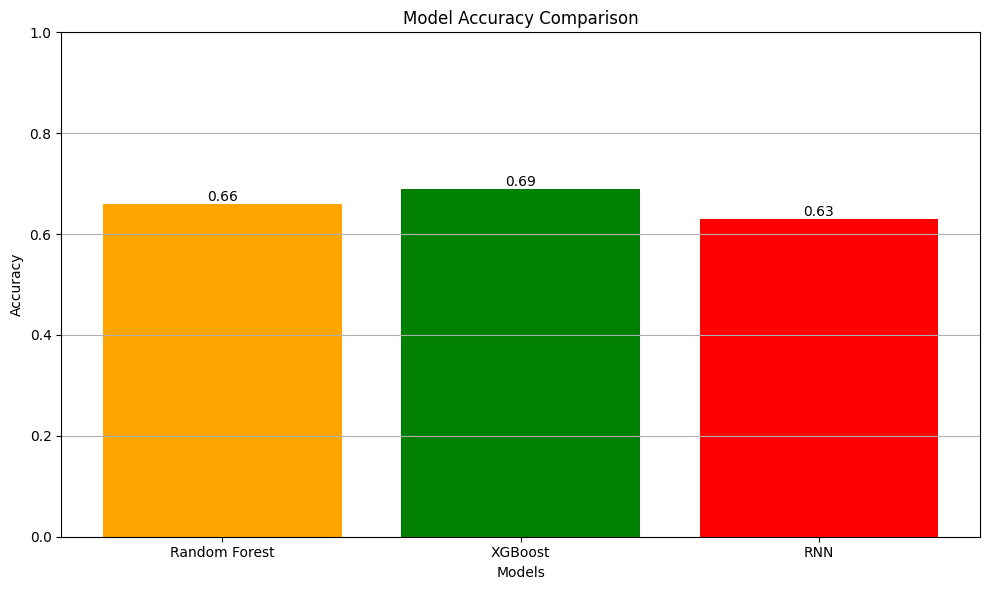

In [78]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color=['orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y')

for index, value in enumerate(accuracy_scores):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()